## Pengklasifikasi Masakan 1

Dalam pelajaran ini, kita akan menjelajahi berbagai pengklasifikasi untuk *memprediksi jenis masakan nasional berdasarkan sekumpulan bahan.* Sambil melakukannya, kita juga akan mempelajari lebih lanjut tentang beberapa cara algoritma dapat dimanfaatkan untuk tugas klasifikasi.

### [**Kuis sebelum pelajaran**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Persiapan**

Pelajaran ini melanjutkan dari [pelajaran sebelumnya](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) di mana kita:

-   Membuat pengenalan sederhana tentang klasifikasi menggunakan dataset tentang berbagai jenis masakan Asia dan India yang luar biasa 😋.

-   Mengeksplorasi beberapa [kata kerja dplyr](https://dplyr.tidyverse.org/) untuk mempersiapkan dan membersihkan data kita.

-   Membuat visualisasi yang indah menggunakan ggplot2.

-   Menunjukkan cara menangani data yang tidak seimbang dengan memprosesnya menggunakan [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Menunjukkan cara `prep` dan `bake` resep kita untuk memastikan bahwa resep tersebut berfungsi sebagaimana mestinya.

#### **Prasyarat**

Untuk pelajaran ini, kita memerlukan paket-paket berikut untuk membersihkan, mempersiapkan, dan memvisualisasikan data kita:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) adalah [koleksi paket R](https://www.tidyverse.org/packages) yang dirancang untuk membuat ilmu data lebih cepat, mudah, dan menyenangkan!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) adalah [kerangka kerja](https://www.tidymodels.org/packages/) yang terdiri dari koleksi paket untuk pemodelan dan pembelajaran mesin.

-   `themis`: Paket [themis](https://themis.tidymodels.org/) menyediakan Langkah Resep Tambahan untuk Menangani Data yang Tidak Seimbang.

-   `nnet`: Paket [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) menyediakan fungsi untuk memperkirakan jaringan saraf feed-forward dengan satu lapisan tersembunyi, dan untuk model regresi logistik multinomial.

Anda dapat menginstalnya dengan:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Sebagai alternatif, skrip di bawah ini akan memeriksa apakah Anda memiliki paket yang diperlukan untuk menyelesaikan modul ini dan akan menginstalnya untuk Anda jika belum tersedia.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Pisahkan data menjadi set pelatihan dan pengujian.

Kita akan mulai dengan mengambil beberapa langkah dari pelajaran sebelumnya.

### Hapus bahan-bahan yang paling umum yang sering menimbulkan kebingungan antara masakan yang berbeda, menggunakan `dplyr::select()`.

Semua orang suka nasi, bawang putih, dan jahe!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Bagus! Sekarang, saatnya membagi data sehingga 70% data digunakan untuk pelatihan dan 30% untuk pengujian. Kita juga akan menerapkan teknik `stratifikasi` saat membagi data untuk `mempertahankan proporsi setiap jenis masakan` dalam dataset pelatihan dan validasi.

[rsample](https://rsample.tidymodels.org/), sebuah paket dalam Tidymodels, menyediakan infrastruktur untuk pembagian data dan resampling yang efisien:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Mengatasi Data yang Tidak Seimbang

Seperti yang mungkin Anda perhatikan pada data asli maupun pada set pelatihan kita, terdapat distribusi jumlah masakan yang cukup tidak merata. Masakan Korea *hampir* 3 kali lebih banyak dibandingkan masakan Thailand. Data yang tidak seimbang sering kali memiliki dampak negatif pada kinerja model. Banyak model bekerja paling baik ketika jumlah observasi seimbang, sehingga cenderung kesulitan dengan data yang tidak seimbang.

Ada dua cara utama untuk mengatasi data yang tidak seimbang:

-   menambahkan observasi pada kelas minoritas: `Over-sampling`, misalnya menggunakan algoritma SMOTE yang secara sintetis menghasilkan contoh baru dari kelas minoritas dengan menggunakan tetangga terdekat dari kasus-kasus tersebut.

-   menghapus observasi dari kelas mayoritas: `Under-sampling`

Dalam pelajaran sebelumnya, kita telah mendemonstrasikan cara mengatasi data yang tidak seimbang menggunakan sebuah `recipe`. Recipe dapat dianggap sebagai cetak biru yang menjelaskan langkah-langkah apa saja yang harus diterapkan pada sebuah data agar siap untuk analisis. Dalam kasus kita, kita ingin memiliki distribusi yang seimbang dalam jumlah masakan pada `training set` kita. Mari kita langsung mulai.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Anda tentu saja dapat melanjutkan (menggunakan prep+bake) untuk memastikan bahwa resep ini akan bekerja seperti yang Anda harapkan - semua label masakan memiliki `559` observasi.

Karena kita akan menggunakan resep ini sebagai praprosesor untuk pemodelan, sebuah `workflow()` akan melakukan semua persiapan dan pemrosesan untuk kita, sehingga kita tidak perlu memperkirakan resep secara manual.

Sekarang kita siap untuk melatih model 👩‍💻👨‍💻!

## 3. Memilih klasifikator Anda

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Karya seni oleh @allison_horst</figcaption>


Sekarang kita harus memutuskan algoritma mana yang akan digunakan untuk tugas ini 🤔.

Dalam Tidymodels, [`paket parsnip`](https://parsnip.tidymodels.org/index.html) menyediakan antarmuka yang konsisten untuk bekerja dengan model di berbagai mesin (paket). Silakan lihat dokumentasi parsnip untuk menjelajahi [jenis model & mesin](https://www.tidymodels.org/find/parsnip/#models) serta [argumen model](https://www.tidymodels.org/find/parsnip/#model-args) yang sesuai. Variasinya cukup membingungkan pada pandangan pertama. Sebagai contoh, metode berikut semuanya mencakup teknik klasifikasi:

-   Model Klasifikasi Berbasis Aturan C5.0

-   Model Diskriminan Fleksibel

-   Model Diskriminan Linear

-   Model Diskriminan Teregularisasi

-   Model Regresi Logistik

-   Model Regresi Multinomial

-   Model Naive Bayes

-   Support Vector Machines

-   Tetangga Terdekat

-   Pohon Keputusan

-   Metode Ensemble

-   Jaringan Neural

Daftarnya terus berlanjut!

### **Klasifikator mana yang harus dipilih?**

Jadi, klasifikator mana yang harus Anda pilih? Sering kali, mencoba beberapa dan mencari hasil yang baik adalah cara untuk menguji.

> AutoML menyelesaikan masalah ini dengan rapi dengan menjalankan perbandingan ini di cloud, memungkinkan Anda memilih algoritma terbaik untuk data Anda. Coba [di sini](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Selain itu, pilihan klasifikator tergantung pada masalah kita. Sebagai contoh, ketika hasilnya dapat dikategorikan ke dalam `lebih dari dua kelas`, seperti dalam kasus kita, Anda harus menggunakan `algoritma klasifikasi multikelas` dibandingkan dengan `klasifikasi biner.`

### **Pendekatan yang lebih baik**

Pendekatan yang lebih baik daripada menebak secara acak adalah mengikuti ide-ide dalam [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) yang dapat diunduh ini. Di sini, kita menemukan bahwa, untuk masalah multikelas kita, kita memiliki beberapa pilihan:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Bagian dari Cheat Sheet Algoritma Microsoft, merinci opsi klasifikasi multikelas</figcaption>


### **Penalaran**

Mari kita coba memahami berbagai pendekatan yang dapat digunakan mengingat batasan yang ada:

-   **Jaringan Neural Mendalam terlalu berat**. Mengingat dataset kita yang bersih namun minimal, serta fakta bahwa kita menjalankan pelatihan secara lokal melalui notebook, jaringan neural mendalam terlalu berat untuk tugas ini.

-   **Tidak menggunakan pengklasifikasi dua kelas**. Kita tidak menggunakan pengklasifikasi dua kelas, sehingga pendekatan one-vs-all tidak relevan.

-   **Pohon keputusan atau regresi logistik bisa digunakan**. Pohon keputusan mungkin cocok, atau regresi multinomial/regresi logistik multikelas untuk data multikelas.

-   **Pohon Keputusan Boosted Multikelas menyelesaikan masalah yang berbeda**. Pohon keputusan boosted multikelas lebih cocok untuk tugas nonparametrik, misalnya tugas yang dirancang untuk membangun peringkat, sehingga tidak berguna untuk kita.

Selain itu, biasanya sebelum mencoba model pembelajaran mesin yang lebih kompleks seperti metode ensemble, ada baiknya membangun model yang paling sederhana untuk mendapatkan gambaran awal tentang apa yang sedang terjadi. Jadi untuk pelajaran ini, kita akan memulai dengan model `regresi multinomial`.

> Regresi logistik adalah teknik yang digunakan ketika variabel hasil bersifat kategorikal (atau nominal). Untuk regresi logistik biner, jumlah variabel hasil adalah dua, sedangkan untuk regresi logistik multinomial jumlah variabel hasil lebih dari dua. Lihat [Metode Regresi Lanjutan](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) untuk bacaan lebih lanjut.

## 4. Melatih dan mengevaluasi model regresi logistik multinomial.

Dalam Tidymodels, `parsnip::multinom_reg()`, mendefinisikan model yang menggunakan prediktor linear untuk memprediksi data multikelas menggunakan distribusi multinomial. Lihat `?multinom_reg()` untuk berbagai cara/mesin yang dapat Anda gunakan untuk melatih model ini.

Untuk contoh ini, kita akan melatih model regresi multinomial menggunakan mesin default [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Saya memilih nilai untuk `penalty` secara acak. Ada cara yang lebih baik untuk memilih nilai ini, yaitu dengan menggunakan `resampling` dan `tuning` model yang akan kita bahas nanti.
>
> Lihat [Tidymodels: Memulai](https://www.tidymodels.org/start/tuning/) jika Anda ingin mempelajari lebih lanjut tentang cara menyetel hiperparameter model.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Kerja bagus 🥳! Sekarang kita sudah memiliki resep dan spesifikasi model, kita perlu mencari cara untuk menggabungkan keduanya menjadi sebuah objek yang akan pertama-tama melakukan praproses data, kemudian menyesuaikan model pada data yang telah dipraproses, dan juga memungkinkan aktivitas pasca-pemrosesan jika diperlukan. Dalam Tidymodels, objek yang praktis ini disebut [`workflow`](https://workflows.tidymodels.org/) dan dengan mudah menyimpan komponen pemodelan Anda! Ini adalah apa yang kita sebut *pipelines* dalam *Python*.

Jadi, mari kita gabungkan semuanya ke dalam sebuah workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Alur kerja 👌👌! Sebuah **`workflow()`** dapat disesuaikan dengan cara yang hampir sama seperti sebuah model. Jadi, saatnya melatih model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Output menunjukkan koefisien yang dipelajari oleh model selama pelatihan.

### Mengevaluasi Model yang Telah Dilatih

Saatnya melihat bagaimana kinerja model 📏 dengan mengevaluasinya pada set pengujian! Mari kita mulai dengan membuat prediksi pada set pengujian.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Kerja bagus! Dalam Tidymodels, evaluasi kinerja model dapat dilakukan menggunakan [yardstick](https://yardstick.tidymodels.org/) - sebuah paket yang digunakan untuk mengukur efektivitas model menggunakan metrik kinerja. Seperti yang kita lakukan dalam pelajaran regresi logistik, mari kita mulai dengan menghitung matriks kebingungan.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Saat berurusan dengan beberapa kelas, umumnya lebih intuitif untuk memvisualisasikannya sebagai peta panas, seperti ini:


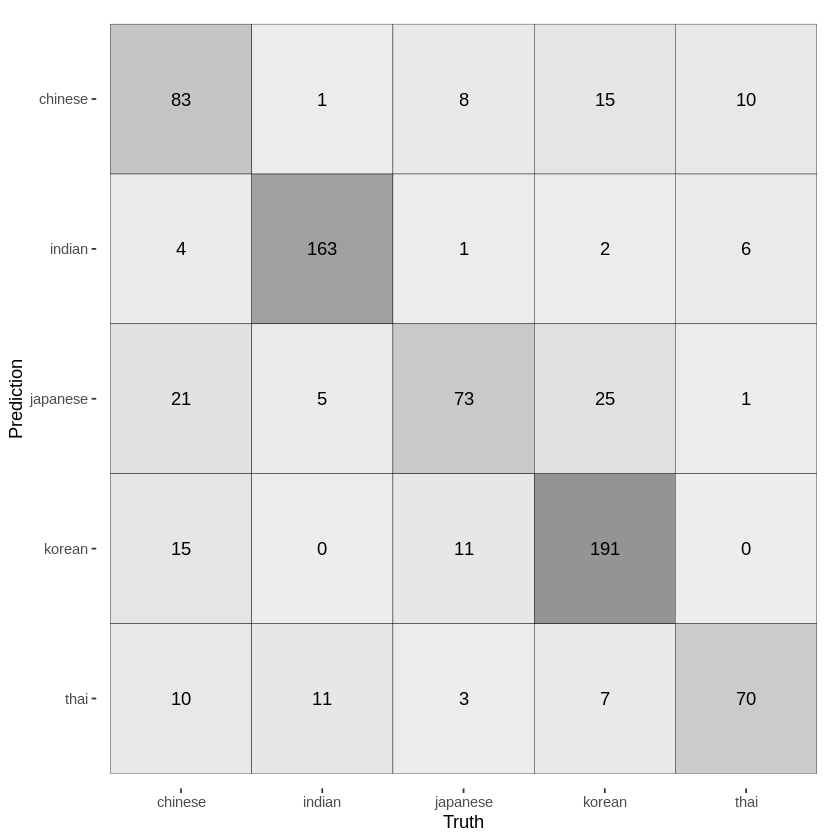

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Kotak yang lebih gelap dalam plot matriks kebingungan menunjukkan jumlah kasus yang tinggi, dan semoga Anda dapat melihat garis diagonal kotak yang lebih gelap yang menunjukkan kasus di mana label prediksi dan label aktual sama.

Sekarang, mari kita hitung statistik ringkasan untuk matriks kebingungan.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Jika kita mempersempit metrik seperti akurasi, sensitivitas, ppv, kita tidak terlalu buruk untuk permulaan 🥳!

## 4. Menyelami Lebih Dalam

Mari kita ajukan satu pertanyaan yang lebih mendalam: Kriteria apa yang digunakan untuk menentukan jenis masakan tertentu sebagai hasil prediksi?

Nah, algoritma pembelajaran mesin statistik, seperti regresi logistik, didasarkan pada `probabilitas`; jadi apa yang sebenarnya diprediksi oleh sebuah classifier adalah distribusi probabilitas atas serangkaian kemungkinan hasil. Kelas dengan probabilitas tertinggi kemudian dipilih sebagai hasil yang paling mungkin untuk pengamatan yang diberikan.

Mari kita lihat ini dalam praktik dengan membuat prediksi kelas keras dan probabilitas.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Bisakah Anda menjelaskan mengapa model cukup yakin bahwa pengamatan pertama adalah masakan Thailand?

## **🚀Tantangan**

Dalam pelajaran ini, Anda menggunakan data yang telah dibersihkan untuk membangun model pembelajaran mesin yang dapat memprediksi jenis masakan nasional berdasarkan serangkaian bahan. Luangkan waktu untuk membaca [banyak opsi](https://www.tidymodels.org/find/parsnip/#models) yang disediakan oleh Tidymodels untuk mengklasifikasikan data dan [cara lain](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) untuk menerapkan regresi multinomial.

#### TERIMA KASIH KEPADA:

[`Allison Horst`](https://twitter.com/allison_horst/) atas ilustrasi luar biasa yang membuat R lebih ramah dan menarik. Temukan lebih banyak ilustrasi di [galerinya](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) dan [Jen Looper](https://www.twitter.com/jenlooper) atas pembuatan versi Python asli dari modul ini ♥️

<br>
Sebenarnya ingin menyisipkan beberapa lelucon, tapi saya tidak terlalu paham permainan kata tentang makanan 😅.

<br>

Selamat Belajar,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan layanan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Meskipun kami berupaya untuk memberikan hasil yang akurat, harap diperhatikan bahwa terjemahan otomatis mungkin mengandung kesalahan atau ketidakakuratan. Dokumen asli dalam bahasa aslinya harus dianggap sebagai sumber yang berwenang. Untuk informasi yang bersifat kritis, disarankan menggunakan jasa penerjemah manusia profesional. Kami tidak bertanggung jawab atas kesalahpahaman atau penafsiran yang keliru yang timbul dari penggunaan terjemahan ini.
